# CREATE BACKGROUNDS, BLADE, PLOT, CORRECT SIZES

In [1]:
# === IMPORTS ===
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from tqdm import tqdm

# === CONFIGURATION ===
blade_color = "orange"
vein_color = "magenta"
overlay_alpha = 0.7
plot_dpi = 100
MAX_DIMENSION = 2048

input_csv = "files_to_use.csv"
image_extensions = [".jpg", ".jpeg", ".tif", ".tiff"]

output_dirs = {
    "background": "BACKGROUNDS",
    "blade": "BLADE",
    "veins": "VEINS",
    "plots": "PLOTS"
}
for d in output_dirs.values():
    os.makedirs(d, exist_ok=True)

# === HELPERS ===
def read_coords(path):
    return np.loadtxt(path)

def resolve_image_path(image_folder, image_value):
    name, ext = os.path.splitext(image_value)
    candidates = [image_value] if ext else [f"{image_value}{e}" for e in image_extensions]
    all_files = os.listdir(image_folder)
    for candidate in candidates:
        for f in all_files:
            if f.lower() == candidate.lower():
                return os.path.join(image_folder, f)
    raise FileNotFoundError(f"No image found for base name {image_value} in {image_folder}")

def rotate_to_wide(img, coords):
    if img.width >= img.height:
        return img, coords
    img_rot = img.transpose(Image.Transpose.ROTATE_90)
    coords_rot = np.copy(coords)
    coords_rot[:, [0, 1]] = coords[:, [1, 0]]
    coords_rot[:, 1] = img.width - coords_rot[:, 1]
    return img_rot, coords_rot

def downscale_to_max_dim(size, max_dim):
    w, h = size
    scale = min(max_dim / max(w, h), 1.0)
    return int(w * scale), int(h * scale), scale

def transform_coords(coords, orig_size, new_size):
    scale = min(new_size[0] / orig_size[0], new_size[1] / orig_size[1])
    coords_scaled = coords * scale
    pad_x = (new_size[0] - orig_size[0] * scale) / 2
    pad_y = (new_size[1] - orig_size[1] * scale) / 2
    coords_trans = coords_scaled + [pad_x, pad_y]
    return coords_trans

def rescale_and_pad_image(img, target_size):
    img = ImageOps.contain(img, target_size)
    padded = Image.new("RGB", target_size, (255, 255, 255))
    paste_pos = ((target_size[0] - img.width) // 2, (target_size[1] - img.height) // 2)
    padded.paste(img, paste_pos)
    return padded

# === PHASE 1: Determine Target Size ===
df = pd.read_csv(input_csv)

max_width, max_height = 0, 0

print("🔍 Scanning for maximum dimensions...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        dataset, sub, fid = row["dataset"], row["subdataset"], row["id"]
        if dataset == "ALGERIA":
            base = os.path.join("ALGERIA", f"{fid}_info.csv")
            meta = pd.read_csv(base)
            imgval = meta.loc[meta["factor"] == "image", "value"].values[0]
            imgpath = resolve_image_path("ALGERIA", imgval)
        else:
            base = os.path.join("PREVIOUS_DATA", f"{sub.lower()}_data", f"{fid}_info.csv")
            meta = pd.read_csv(base)
            imgval = meta.loc[meta["factor"] == "image", "value"].values[0]
            imgpath = resolve_image_path(os.path.join("PREVIOUS_DATA", f"{sub.lower()}_images"), imgval)

        im = Image.open(imgpath).convert("RGB")
        if im.width < im.height:
            im = im.transpose(Image.Transpose.ROTATE_90)

        max_width = max(max_width, im.width)
        max_height = max(max_height, im.height)

    except Exception as e:
        print(f"⚠️ Skipping {fid}: {e}")

target_width, target_height, _ = downscale_to_max_dim((max_width, max_height), MAX_DIMENSION)
target_size = (target_width, target_height)
print(f"📐 Target image size (max {MAX_DIMENSION}px): {target_size}")

# === PHASE 2: Generate and Save ===
print("🚀 Processing and saving outputs...")
name_counter = {}

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        dataset, sub, fid, name = row["dataset"], row["subdataset"], row["id"], row["name"]
        name_base = name.strip()
        count = name_counter.get(name_base, 0) + 1
        name_counter[name_base] = count
        outname = f"{name_base}_{count}" if count > 1 else name_base

        if dataset == "ALGERIA":
            base_dir = "ALGERIA"
            img_info = pd.read_csv(os.path.join(base_dir, f"{fid}_info.csv"))
            imgval = img_info.loc[img_info["factor"] == "image", "value"].values[0]
            imgpath = resolve_image_path(base_dir, imgval)
            blade_path = os.path.join(base_dir, f"{fid}_blade.txt")
            vein_path = os.path.join(base_dir, f"{fid}_veins.txt")
        else:
            base_d = os.path.join("PREVIOUS_DATA", f"{sub.lower()}_data")
            img_d = os.path.join("PREVIOUS_DATA", f"{sub.lower()}_images")
            img_info = pd.read_csv(os.path.join(base_d, f"{fid}_info.csv"))
            imgval = img_info.loc[img_info["factor"] == "image", "value"].values[0]
            imgpath = resolve_image_path(img_d, imgval)
            blade_suffix = "_blades.txt" if sub == "UCD" else "_blade.txt"
            blade_path = os.path.join(base_d, f"{fid}{blade_suffix}")
            vein_path = os.path.join(base_d, f"{fid}_veins.txt")

        if not os.path.exists(blade_path) or not os.path.exists(vein_path):
            continue

        img_orig = Image.open(imgpath).convert("RGB")
        blade = read_coords(blade_path)
        vein = read_coords(vein_path)

        # ✅ Rotate both using the ORIGINAL image
        img_rot, blade_rot = rotate_to_wide(img_orig, blade)
        _, vein_rot = rotate_to_wide(img_orig, vein)

        # ✅ Rescale and pad background image
        img_trans = rescale_and_pad_image(img_rot, target_size)

        # ✅ Apply same transformation to coordinates
        blade_trans = transform_coords(blade_rot, img_rot.size, target_size)
        vein_trans = transform_coords(vein_rot, img_rot.size, target_size)

        # === SAVE FILES ===
        img_trans.save(os.path.join(output_dirs["background"], outname + ".png"))
        np.savetxt(os.path.join(output_dirs["blade"], outname + "_blade.txt"), blade_trans, fmt="%.2f")
        np.savetxt(os.path.join(output_dirs["veins"], outname + "_veins.txt"), vein_trans, fmt="%.2f")

        fig, ax = plt.subplots()
        ax.imshow(img_trans)
        ax.add_patch(Polygon(blade_trans, closed=True, color=blade_color, alpha=overlay_alpha))
        ax.add_patch(Polygon(vein_trans, closed=True, color=vein_color, alpha=overlay_alpha))
        ax.axis("off")
        fig.savefig(os.path.join(output_dirs["plots"], outname + ".png"), dpi=plot_dpi, bbox_inches="tight", pad_inches=0.1)
        plt.close()

    except Exception as e:
        print(f"⚠️ Skipping {row['id']}: {e}")

print("✅ All files processed and saved.")


🔍 Scanning for maximum dimensions...


100%|█████████████████████████████████████████| 208/208 [00:16<00:00, 12.91it/s]


📐 Target image size (max 2048px): (2048, 1447)
🚀 Processing and saving outputs...


100%|█████████████████████████████████████████| 208/208 [02:51<00:00,  1.21it/s]

✅ All files processed and saved.


# GENERATE MASKS

In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

# === CONFIGURATION ===
background_dir = "BACKGROUNDS"
blade_dir = "BLADE"
veins_dir = "VEINS"
mask_dir = "MASKS"
os.makedirs(mask_dir, exist_ok=True)

# === GET IMAGE NAMES ===
image_files = [f for f in os.listdir(background_dir) if f.lower().endswith(".png")]

# === PROCESS EACH IMAGE ===
for fname in tqdm(image_files):
    name = os.path.splitext(fname)[0]
    background_path = os.path.join(background_dir, fname)
    blade_path = os.path.join(blade_dir, f"{name}_blade.txt")
    vein_path = os.path.join(veins_dir, f"{name}_veins.txt")
    mask_path = os.path.join(mask_dir, f"{name}.png")

    # Skip if already exists
    if os.path.exists(mask_path):
        continue

    # Load image to get size
    bg_img = Image.open(background_path)
    w, h = bg_img.size

    # Create blank mask (uint8): background = 0
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)

    # Draw blade: label = 1
    if os.path.exists(blade_path):
        blade_coords = np.loadtxt(blade_path)
        blade_coords_tuple = [tuple(pt) for pt in blade_coords]
        draw.polygon(blade_coords_tuple, fill=1)

    # Draw veins: label = 2 (overwrite blade if overlapping)
    if os.path.exists(vein_path):
        vein_coords = np.loadtxt(vein_path)
        vein_coords_tuple = [tuple(pt) for pt in vein_coords]
        draw.polygon(vein_coords_tuple, fill=2)

    # Save mask as image
    mask.save(mask_path)

print("✅ All masks created and saved to MASKS/")


100%|█████████████████████████████████████████| 208/208 [00:05<00:00, 39.75it/s]

✅ All masks created and saved to MASKS/


# CHECK MASKS ARE WORKING

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

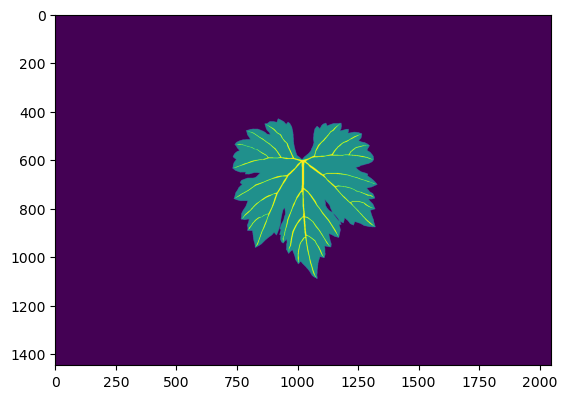

In [8]:
img = Image.open("./MASKS/Ahmeur Bou Ahmeur_7.png") # Replace "image.jpg" with your image file path
# Display the image
plt.imshow(img)

# FINAL CHECK

In [2]:
# === IMPORTS ===
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm

# === CONFIGURATION ===
background_dir = "MODIFIED_BACKGROUNDS"
mask_dir = "MASKS"
output_dir = "FINAL_CHECK"
os.makedirs(output_dir, exist_ok=True)

# Colors: 0 = transparent, 1 = orange (blade), 2 = magenta (veins)
cmap = ListedColormap([
    (0, 0, 0, 0),         # background -> fully transparent
    (1.0, 0.55, 0.0, 0.7),  # blade -> orange, semi-transparent
    (1.0, 0.0, 1.0, 0.7),  # veins -> magenta, semi-transparent
])

# === PROCESSING ===
for fname in tqdm(sorted(os.listdir(background_dir))):
    if not fname.lower().endswith(".png"):
        continue

    bg_path = os.path.join(background_dir, fname)
    mask_path = os.path.join(mask_dir, fname)

    if not os.path.exists(mask_path):
        print(f"⚠️ Missing mask for {fname}, skipping...")
        continue

    # Load images
    bg_img = Image.open(bg_path).convert("RGB")
    mask_img = Image.open(mask_path)
    mask = np.array(mask_img)

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    
    # Original background
    axs[0].imshow(bg_img)
    axs[0].axis("off")
    #axs[0].set_title("Modified Background")

    # Overlay: show background + mask overlay (with transparent background)
    axs[1].imshow(bg_img)
    axs[1].imshow(mask, cmap=cmap, interpolation="none")
    axs[1].axis("off")
    #axs[1].set_title("Overlay: Blade (orange), Veins (magenta)")

    # Save output
    out_path = os.path.join(output_dir, fname)
    plt.tight_layout()
    plt.savefig(out_path, dpi=100, bbox_inches="tight", pad_inches=0.1)
    plt.close()

print("✅ All overlays saved to FINAL_CHECK.")


100%|█████████████████████████████████████████| 208/208 [02:18<00:00,  1.50it/s]

✅ All overlays saved to FINAL_CHECK.
